<h1><center> Quantitative Finance Bootcamp Erdos Institute <center></h1>
<h1><center> Mini project 1: Building a Custom Portfolio - Strategies to Outperform the Market!</center></h1>
    
## Project Summary

This project centers on constructing two investment portfolios—a high-risk portfolio and a low-risk portfolio—using simple yet powerful concepts like diversification, as taught in the bootcamp. To build these portfolios, we incorporated techniques such as pairwise correlation analysis and the Capital Asset Pricing Model (CAPM), leveraging the beta ($\beta$) statistic to assess stock volatility relative to the broader market.

## Strategy for constructing portoflios

- We began by calculating the beta of various sectors using historical data, then applied CAPM to estimate their expected returns. Beta measures how much a sector’s price fluctuates compared to the overall market, making it a key indicator of risk. According to CAPM, a higher beta not only indicates higher risk but also suggests the potential for higher returns, as investors are compensated for taking on additional risk. Sectors with high beta values (β > 1) were therefore considered for the high-risk portfolio, while those with low beta values (β < 1) were selected for the low-risk portfolio. This beta analysis also allowed us to initially characterize the top financial sectors of the stock market, providing insight into their risk profiles.

- Next, we performed a pairwise correlation analysis to evaluate how different financial sectors move in relation to one another. By choosing sectors with lower positive correlations, we enhanced the diversification of both portfolios, reducing the likelihood that all sectors would decline simultaneously. This step aligns with our goal of building resilient portfolios using data-driven strategies.

- For the low-risk portfolio, we integrated beta analysis, correlation studies, and mean-variance optimization from modern portfolio theory. We first identified sectors characterized by low beta values and weak positive correlations with each other. Within these sectors, we selected the five stocks with the lowest beta values from their top holdings, and then applied mean-variance optimization to determine optimal weights that minimize volatility. This comprehensive strategy produced a portfolio less volatile than the broader market, improving its stability during sector-specific downturns and making it more resilient to overall market fluctuations.

- For the high-risk portfolio, we first selected sectors with high beta values. From the top holdings within these sectors, we chose the five stocks with the highest betas. We then assigned weights to these stocks proportional to their beta values, deliberately accepting higher risk in pursuit of greater potential returns.

Through this project, we showcase how fundamental investment principles—diversification, beta analysis, and correlation studies—can be applied to construct portfolios tailored to different risk preferences, offering practical value in real-world investing. At the end, we will analyze historical ETF and stock data for the past 5 years up to the start date of the bootcamp. Using this data, we will construct a portfolio and evaluate its short-term performance from the beginning to the end of the bootcamp. We get to see how our decisions play out in real market conditions over this short period. This immediate feedback is fascinating because it tests our strategy in real-time, showing you what works, what doesn’t, and how the market’s twists and turns affect the portfolio.

## Assumptions involved in our strategy



## Analysis 1: Characterize sectors based on $\beta$

We keep things simple and consider a few of the top performing sectors of the US stock market. Sector-specific Exchange-Traded Funds (ETFs) or indices are ideal proxies. Here are examples of ETFs for each sector:

- Technology: XLK
- Financials: XLF
- Healthcare: XLV
- Consumer Discretionary: XLY
- Consumer Staples: XLP
- Utilities: XLU
- Energy: XLE
- Industrials: XLI
- Real Estate: XLRE
- Materials: XLB
- Communication Services: XLC

### Importing necessary modules

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
import statsmodels.api as sm
import yfinance as yf
from scipy.optimize import minimize

import matplotlib.dates as mdates 
import matplotlib as mpl
mpl.rcParams["xtick.labelsize"] = 22
mpl.rcParams["ytick.labelsize"] = 22
mpl.rcParams['axes.titlesize'] = 22 
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams["mathtext.fontset"] = 'cm'


### Collect the market data using yfinance for a given period and interval

In [3]:
TickersSectors = ["XLB", "XLC","XLE","XLF","XLI","XLK","XLP","XLRE","XLU","XLV", "XLY"]
Period = "5y"     # Collect the historical data over previous 5 years
Frequency = "1d"  # Set the frequency interval for the data collection

# Download the closing data for given tickers over a given period and interval
SectorsData = yf.download(TickersSectors, period=Period, interval=Frequency)["Close"]
StartDate = dt.datetime(2020, 5, 1)
EndDate = dt.datetime(2025, 5, 1)
# Comparison with the market index - We use S&P 500
MarketTicker = 'SPY'  # S&P 500
MarketData = yf.download(MarketTicker, start=StartDate, end=EndDate, interval=Frequency)["Close"]

/var/folders/nn/r9r3k78j2q12py3xmz4vtgzc0000gn/T/ipykernel_59343/2679142218.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  SectorsData = yf.download(TickersSectors, period=Period, interval=Frequency)["Close"]
[*********************100%***********************]  11 of 11 completed
/var/folders/nn/r9r3k78j2q12py3xmz4vtgzc0000gn/T/ipykernel_59343/2679142218.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  MarketData = yf.download(MarketTicker, start=StartDate, end=EndDate, interval=Frequency)["Close"]
[*********************100%***********************]  1 of 1 completed


## Computation of $\beta$

The beta ($\beta$) of an asset measures its sensitivity to market movements, a key metric for assessing risk in portfolio construction. Mathematically, for an asset $i$ observed over $t$ periods, $\beta_i$ is derived from a linear regression of the asset’s rate of returns $R_{i,t}$ against the rate of returns $R_{m,t}$ of a market index $m$ (such as the S&P 500):

\begin{equation}
R_{i,t} = \alpha_i + \beta_i R_{m,t} + \varepsilon_{i,t} 
\end{equation}

Here, $\alpha_i$ is the intercept, $\beta_i$ is the slope, and $\varepsilon_{i,t}$ is the error term. The slope $\beta_i$, representing the asset’s beta, is calculated as:

\begin{equation}
    \beta_i = \frac{\text{Cov}(R_i, R_m)}{\text{Var}(R_m)}, 
\end{equation}

where $\text{Cov}(R_i, R_m)$ is the covariance between the asset’s returns and the market’s returns, and $\text{Var}(R_m)$ is the variance of the market’s returns.

In practice, we estimate $\beta$ by performing an ordinary least squares (OLS) regression, fitting the asset’s historical returns to the market’s returns over a chosen time period, such as five years. This approach quantifies how much an asset’s price tends to move with the market, informing our selection of stocks for high-risk or low-risk portfolios. 

In [4]:
def ComputeBeta(Ticker = "XLK", MarketTicker = "SPY", EndDate = "2025-5-1", Period = "5y", Frequency = "1d"):
    """
    Info: Computes the beta of a given asset by performing OLS fit between asset's historical returns to the 
          market’s returns over a chosen time period.
    
    Params: 
        - Ticker (str)              : Ticker index for the asset
        - MarketTicker (str)        : Ticker for market proxy
        - EndDate (str or datetime) : End date to download the historical data
        - Frequency (str)           : Frequency of the data (daily, weekly)
        - Period (str)              : Duration of time to collect asset data
    """
    StartDate = EndDate - pd.DateOffset(years=int(Period[0]))
    StockData = yf.download(Ticker, start=StartDate, end=EndDate, interval=Frequency)["Close"]
    MarketData = yf.download(MarketTicker, start=StartDate, end=EndDate, interval=Frequency)["Close"]
    ReturnsStock = StockData.pct_change().dropna(how="all") 
    ReturnsMarket = MarketData.pct_change().dropna(how="all")
    ReturnsMarket = ReturnsMarket[~ReturnsStock.isna().any(axis=1)]
    ReturnsStock = ReturnsStock.dropna()
    
    ReturnsMarket = sm.add_constant(ReturnsMarket)   # Adds a column of 1s for OLS
    model = sm.OLS(ReturnsStock, ReturnsMarket).fit()
    MarketTicker = ReturnsMarket.columns[1]
    beta = model.params
    
    return beta

### Compute the beta for various sectors

In [5]:
BetaModelParams = ComputeBeta(Ticker = TickersSectors, EndDate = EndDate, Period="5y", Frequency = Frequency)
Beta = pd.DataFrame({'Sector': TickersSectors, 'Beta':BetaModelParams.iloc[1].values})

/var/folders/nn/r9r3k78j2q12py3xmz4vtgzc0000gn/T/ipykernel_59343/985903268.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  StockData = yf.download(Ticker, start=StartDate, end=EndDate, interval=Frequency)["Close"]
[*********************100%***********************]  11 of 11 completed
/var/folders/nn/r9r3k78j2q12py3xmz4vtgzc0000gn/T/ipykernel_59343/985903268.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  MarketData = yf.download(MarketTicker, start=StartDate, end=EndDate, interval=Frequency)["Close"]
[*********************100%***********************]  1 of 1 completed


### Sort the sectors based on $\beta$

In [6]:
df = pd.DataFrame(Beta)
BetaSorted = df.sort_values(by='Beta', ascending=False)
BetaSorted

,Sector,Beta
5,XLK,1.306649
10,XLY,1.188110
1,XLC,1.042155
3,XLF,0.926896
0,XLB,0.907803
4,XLI,0.900210
2,XLE,0.846382
7,XLRE,0.791880
9,XLV,0.597652
8,XLU,0.508945


## Computing expected return of an asset using CAPM 

The Capital Asset Pricing Model (CAPM) is a financial model that calculates the expected return of an asset based on its risk relative to the market. It is widely used to determine the required rate of return for an asset, factoring in systematic risk ($\beta).

The CAPM formula is:

\begin{equation}
E(R_i) = R_f + \beta_i (E(R_m) - R_f),
\end{equation}

where:
- $E(R_i)$ : Expected return of the asset.
- $R_f$ : Risk-free rate (e.g., return on Treasury bills).
- $\beta_i$: Beta of the asset, as defined before.
- $E(R_m)$: Expected return of the market.

The term $(E(R_m) - R_f)$ is the market risk premium, representing the extra return investors expect for taking on market risk over a risk-free investment. CAPM uses beta to show how much return an asset should provide given its level of systematic risk.

In practice, the expected market rate of return is usually estimated by measuring the geometric average of the historical returns of market (S&P 500) and the risk free rate of return used for determining the market risk premium is usually the geometric average of historical risk free rates of return. Here we use the historical US treasury rates.

### Obtain the annual returns for the market averaged over 5 years

In [7]:
def ComputeHistoricalAvgReturns(Ticker = "SPY", EndDate = "2025-5-1", period = "5y"):
    """
    Info: Computes the geometric average of the historical returns of market over a period. 
    
    Params:
        - Ticker (str)              : Ticker index for the market (default value of SPY)
        - EndDate (str or datetime) : End date to download the historical data
        - Period (str)              : Duration of time to collect asset data
    
    """
    
    StartDate = EndDate - pd.DateOffset(years=int(period[0]))
    data = yf.download(Ticker, start=StartDate, end=EndDate)
    data["Year"] = data.index.year
    AnnualReturns = data.groupby('Year')['Close'].apply(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0]) + 1
    AnnualReturns = AnnualReturns.to_numpy().reshape(len(AnnualReturns))
    GeomMeanAR = np.prod(AnnualReturns,axis=0)**(1/len(AnnualReturns)) - 1
    
    return GeomMeanAR

MarketReturns = ComputeHistoricalAvgReturns(Ticker = "SPY", EndDate = EndDate, period = "5y")
print(f"Average market returns over a period of 5 years is {MarketReturns*100:.2f}%")

/var/folders/nn/r9r3k78j2q12py3xmz4vtgzc0000gn/T/ipykernel_59343/1401885046.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(Ticker, start=StartDate, end=EndDate)
[*********************100%***********************]  1 of 1 completed

Average market returns over a period of 5 years is 13.63%


### Obtain the risk free rate from US treasury

In [8]:
def ObtainRiskFreeRate(Ticker = "^FVX", EndDate = "2025-5-1", period = "10m"):
    """
    Info: Computes the risk free rate by geometric average of the US treasury rates.
    
    Params:
        - Ticker (str)              : Ticker index for the market (default value of SPY)
        - EndDate (str or datetime) : End date to download the historical data
        - Period (str)              : Duration of time to collect asset data
    """
    
    StartDate = EndDate - pd.DateOffset(months=int(period[0]))
    data = yf.download(Ticker, start=StartDate, end=EndDate)
    data["Month"] = data.index.month
    MonthlyReturns = data.groupby('Month')['Close'].apply(lambda x: x.iloc[-1]/100) + 1
    MonthlyReturns = MonthlyReturns.to_numpy().reshape(len(MonthlyReturns))
                                                        
    AvgRiskFreeRate = np.prod(MonthlyReturns)**(1/len(MonthlyReturns)) - 1
    
    return AvgRiskFreeRate

RiskFreeRate = ObtainRiskFreeRate(Ticker = "^FVX", EndDate = EndDate, period = "10m")
print(f"Average Risk free rate of US treasury over a period of 10 months is {RiskFreeRate*100:.2f}%")

/var/folders/nn/r9r3k78j2q12py3xmz4vtgzc0000gn/T/ipykernel_59343/1713246757.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(Ticker, start=StartDate, end=EndDate)
[*********************100%***********************]  1 of 1 completed

Average Risk free rate of US treasury over a period of 10 months is 3.75%


### Estimating the CAPM price for each sector

In [9]:
AdjustedMarketRate = MarketReturns - RiskFreeRate
CAPM = RiskFreeRate + (Beta['Beta'].to_numpy() * AdjustedMarketRate)
CAPMDict = pd.DataFrame({'Sector': TickersSectors, 'CAPM':CAPM})
df = pd.DataFrame(CAPMDict)
CAPMDictSorted = df.sort_values(by='CAPM', ascending=False)
CAPMDictSorted

,Sector,CAPM
5,XLK,0.166542
10,XLY,0.154837
1,XLC,0.140425
3,XLF,0.129044
0,XLB,0.127159
4,XLI,0.126409
2,XLE,0.121094
7,XLRE,0.115712
9,XLV,0.096534
8,XLU,0.087775


## Pairwise correlation analysis

Pairwise correlation measures the degree to which two sectors’ returns move together. In portfolio management, diversification reduces risk by combining assets that don’t move in lockstep. By analyzing correlations:

High correlations (close to 1) indicate sectors move similarly, reducing diversification benefits.
Low or negative correlations (close to 0 or -1) suggest sectors move independently or oppositely, enhancing diversification.

### Compute the log returns of various sectors

In [10]:
SectorsDataDailyReturns = np.log(SectorsData/SectorsData.shift(1)).dropna()

### Compute the correlation matrix 

In [11]:
CorrMatrix = SectorsDataDailyReturns.corr()

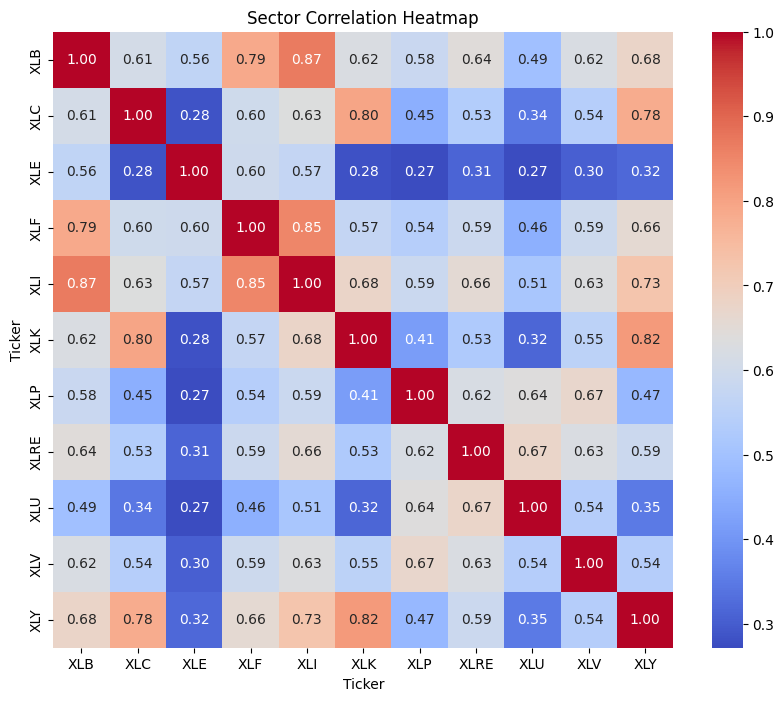

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(CorrMatrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Sector Correlation Heatmap')
plt.show()

## Constructing investment portfolio  

### High-Risk Investment Portfolio

The high-risk portfolio is engineered to maximize growth potential by embracing elevated volatility. We target the four sectors with the highest estimated returns to capitalize on industries with significant upside potential. To handle risk without diluting the aggressive stance, we include one additional sector with a weaker correlation (0.3–0.5) to the primary sectors. Within each sector, we select five stocks with the highest beta, leveraging the Capital Asset Pricing Model (CAPM) to pursue higher returns commensurate with their risk. To keep things simple, we divide the portfolio's capital among the selected stocks weighted by their beta values, ensuring diversification while maintaining a focus on higher growth potential.


### 1. Selecting 4 sectors with higher beta

In [13]:
Top4SectorsHighRisk = BetaSorted["Sector"].head(4).to_list()
Top4SectorsHighRisk

['XLK', 'XLY', 'XLC', 'XLF']

### 2. We also include the utilities sector with a weaker correlation (0.3-0.5) to the primary sectors

In [14]:
Top5SectorsHighRisk = Top4SectorsHighRisk + ["XLU"]
print(Top5SectorsHighRisk)

['XLK', 'XLY', 'XLC', 'XLF', 'XLU']


### 3. Within each sector ETF we select the 5 stocks with the highest beta from the ETF's top holdings.

In [16]:
def BetaTopHoldingStocks(ETFTicker="XLK", EndDate = EndDate, Period="5y", Frequency = Frequency):
    """
    Info : Compute the beta for ETFs top holdings.
    
    Params: 
        - ETFTicker (str) : Ticker of the input ETF
    """
    Ticker = yf.Ticker(ETFTicker)
    data = Ticker.funds_data
    df = data.top_holdings
    StocksTicker = df.index.tolist()
    StocksTicker.sort()
    BetaModelParams = ComputeBeta(Ticker = StocksTicker, EndDate = EndDate, Period="5y", Frequency = Frequency)
    Beta = pd.DataFrame({'Sector': StocksTicker, 'Beta':BetaModelParams.iloc[1].values})
    
    return Beta
    
Top5SectorsBeta = {}
for sector in Top5SectorsHighRisk:
    Top5SectorsBeta[sector] = BetaTopHoldingStocks(ETFTicker=sector)

/var/folders/nn/r9r3k78j2q12py3xmz4vtgzc0000gn/T/ipykernel_59343/985903268.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  StockData = yf.download(Ticker, start=StartDate, end=EndDate, interval=Frequency)["Close"]
[*********************100%***********************]  10 of 10 completed
/var/folders/nn/r9r3k78j2q12py3xmz4vtgzc0000gn/T/ipykernel_59343/985903268.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  MarketData = yf.download(MarketTicker, start=StartDate, end=EndDate, interval=Frequency)["Close"]
[*********************100%***********************]  1 of 1 completed
/var/folders/nn/r9r3k78j2q12py3xmz4vtgzc0000gn/T/ipykernel_59343/985903268.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  StockData = yf.download(Ticker, start=StartDate, end=EndDate, interval=Frequency)["Close"]
[*********************100%***********************]  10 of 10 completed
/var/folders/nn/r9r3k78

### 4. Sort the stocks with highest beta within each sector and finalize the list of stocks in high-risk portfolio

In [17]:
HighRiskPortfolioTickers = []
HighRiskPortfolioTickersBeta = []
for key in Top5SectorsBeta.keys():
    HighRiskPortfolioTickers +=Top5SectorsBeta[key].sort_values(by='Beta', ascending=False).head(5)["Sector"].to_list()
    HighRiskPortfolioTickersBeta += Top5SectorsBeta[key].sort_values(by='Beta', ascending=False).head(5)["Beta"].to_list()

### 5. Assign weights to each stock based on their beta values

In [45]:
BetaNormalized = sum(HighRiskPortfolioTickersBeta)
WeightsHighRiskPortfolio = np.array(HighRiskPortfolioTickersBeta)/BetaNormalized
FinalizedHighRiskPortfolio = dict(zip(HighRiskPortfolioTickers, WeightsHighRiskPortfolio))
FinalizedHighRiskPortfolio = dict(sorted(FinalizedHighRiskPortfolio.items()))

print("Capital Weights in the High-Risk Portfolio")
for key, value in FinalizedHighRiskPortfolio.items():
    print(f"{key}: Weight = {value:.4f}")
    
HighRiskPortfolioTickers = list(FinalizedHighRiskPortfolio.keys())
WeightsHighRiskPortfolio = list(FinalizedHighRiskPortfolio.values())

# WeightsHighRiskPortfolioTickers = FinalizedHighRiskPortfolio.values()
HighRiskStockData = yf.download(HighRiskPortfolioTickers, start=StartDate, end=EndDate, interval=Frequency)["Close"]
HighRiskStockDataLogReturns = np.log(HighRiskStockData/HighRiskStockData.shift(1)).dropna()
AnnualizedVolatilityHR = {ticker: np.std(HighRiskStockDataLogReturns[ticker])*np.sqrt(252) for ticker in HighRiskPortfolioTickers}

AnnualizedVolatilityHRarr = np.array(list(AnnualizedVolatilityHR.values())) 
BetaHR = np.dot(HighRiskPortfolioTickersBeta,WeightsHighRiskPortfolio)
CAPMHighRisk = RiskFreeRate + (BetaHR * AdjustedMarketRate)
print(f"Volatility of the High-Risk Portfolio is {np.dot(AnnualizedVolatilityHRarr,WeightsHighRiskPortfolio)}")
print(f"Beta of the High-Risk Portfolio is {BetaHR}")
print(f"Expected rate of return from CAPM is {CAPMHighRisk}")


/var/folders/nn/r9r3k78j2q12py3xmz4vtgzc0000gn/T/ipykernel_59343/575740090.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  HighRiskStockData = yf.download(HighRiskPortfolioTickers, start=StartDate, end=EndDate, interval=Frequency)["Close"]
[*********************100%***********************]  25 of 25 completed

Capital Weights in the High-Risk Portfolio
AMZN: Weight = 0.0680
AVGO: Weight = 0.0629
AXP: Weight = 0.0504
BAC: Weight = 0.0460
BKNG: Weight = 0.0420
CEG: Weight = 0.0632
CRM: Weight = 0.0449
GOOG: Weight = 0.0383
GOOGL: Weight = 0.0339
GS: Weight = 0.0326
INTU: Weight = 0.0494
LYV: Weight = 0.0402
MA: Weight = 0.0401
META: Weight = 0.0397
NEE: Weight = 0.0397
NFLX: Weight = 0.0391
NKE: Weight = 0.0356
NVDA: Weight = 0.0345
PEG: Weight = 0.0332
PLTR: Weight = 0.0332
SBUX: Weight = 0.0401
SRE: Weight = 0.0380
TSLA: Weight = 0.0191
VST: Weight = 0.0184
WFC: Weight = 0.0174
Volatility of the High-Risk Portfolio is 0.30557381126913885
Beta of the High-Risk Portfolio is 1.357362474045806
Expected rate of return from CAPM is 0.17154965307673947


### Low Risk Investment Portfolio

The low-risk portfolio is designed to prioritize stability and capital preservation by minimizing volatility and pairwise correlations among holdings. We target stocks and sectors with lower betas, aiming for moderate expected returns to balance safety with performance. To enhance diversification, we select four to five sectors with weak correlations (0.3–0.5), deliberately excluding highly correlated sectors to reduce the likelihood of simultaneous downturns. Portfolio weights are optimized using a minimum variance approach, ensuring the lowest possible volatility while adhering to the low-risk mandate. Additionally, to further diversify and avoid over-concentration, each selected sector is allocated at least 10% of the portfolio’s capital.

### 1. Selecting 5 sectors with lesser beta

In [19]:
Top5SectorsLowRisk = BetaSorted["Sector"].tail(5).to_list()
Top5SectorsLowRisk

['XLE', 'XLRE', 'XLV', 'XLU', 'XLP']

### 2. Modifications due to correlations

Removing the real estate sector (XLRE) as it seems highly correlated with almost every other sector. Instead including Communication Services (XLC) to balance it out. 

In [20]:
Top5SectorsLowRisk.remove('XLRE')
Top5SectorsLowRisk.append('XLC')
Top5SectorsLowRisk

['XLE', 'XLV', 'XLU', 'XLP', 'XLC']

### 3. Within each sector ETF we select the 5 stocks with the lower beta from the ETF's top holdings.

In [21]:
Top5SectorsBetaLowRisk = {}
for sector in Top5SectorsLowRisk:
    Top5SectorsBetaLowRisk[sector] = BetaTopHoldingStocks(ETFTicker=sector)

/var/folders/nn/r9r3k78j2q12py3xmz4vtgzc0000gn/T/ipykernel_59343/985903268.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  StockData = yf.download(Ticker, start=StartDate, end=EndDate, interval=Frequency)["Close"]
[*********************100%***********************]  10 of 10 completed
/var/folders/nn/r9r3k78j2q12py3xmz4vtgzc0000gn/T/ipykernel_59343/985903268.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  MarketData = yf.download(MarketTicker, start=StartDate, end=EndDate, interval=Frequency)["Close"]
[*********************100%***********************]  1 of 1 completed
/var/folders/nn/r9r3k78j2q12py3xmz4vtgzc0000gn/T/ipykernel_59343/985903268.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  StockData = yf.download(Ticker, start=StartDate, end=EndDate, interval=Frequency)["Close"]
[*********************100%***********************]  10 of 10 completed
/var/folders/nn/r9r3k78

### 4. Sort the stocks with lower betas within each sector and finalize the list of stocks in low-risk portfolio

In [22]:
LowRiskPortfolioTickers = []
LowRiskPortfolioTickersBeta = []
for key in Top5SectorsBetaLowRisk.keys():
    LowRiskPortfolioTickers +=Top5SectorsBetaLowRisk[key].sort_values(by='Beta', ascending=True).head(5)["Sector"].to_list()
    LowRiskPortfolioTickersBeta += Top5SectorsBetaLowRisk[key].sort_values(by='Beta', ascending=True).head(5)["Beta"].to_list()

### 5. Assign portfolio weights using a minimum variance approach 

Our goal is to find a set of portfolio weights for our capital in our low-risk investment which minimizes a historical portfolio's volatility subject to the following investment constraints:

- The weights should sum to 1. 
- Must invest at least 2% of capital into each index such that each sector has atleast 10% weightage. 
- Cannot invest more than 10% of capital into a single index.

### 5a. Download the stock data for the shortlisted stocks in low-risk and compute annualized volatility

In [23]:
LowRiskStockData = yf.download(LowRiskPortfolioTickers, start=StartDate, end=EndDate, interval=Frequency)["Close"]
LowRiskStockDataLogReturns = np.log(LowRiskStockData/LowRiskStockData.shift(1)).dropna()
AnnualizedVolatility = {ticker: np.std(LowRiskStockDataLogReturns[ticker])*np.sqrt(252) for ticker in LowRiskPortfolioTickers}
CovMatrixLowRiskStock = 252*((LowRiskStockDataLogReturns).cov())

/var/folders/nn/r9r3k78j2q12py3xmz4vtgzc0000gn/T/ipykernel_59343/3243667520.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  LowRiskStockData = yf.download(LowRiskPortfolioTickers, start=StartDate, end=EndDate, interval=Frequency)["Close"]
[*********************100%***********************]  25 of 25 completed


In [43]:
NStocks = len(LowRiskPortfolioTickers)
InitWeights = np.ones(NStocks)/NStocks

Constraints = ({'type': 'eq', 'fun': lambda Weights: np.sum(Weights)-1},
               {'type': 'ineq', 'fun': lambda Weights: min(Weights)-.02},
              {'type': 'ineq', 'fun': lambda Weights: .1-max(Weights)})

def PortfolioVolatility(Weights):
    PortfolioStd = np.sqrt(np.dot(Weights.T, np.dot(CovMatrixLowRiskStock, Weights)))
    return PortfolioStd

Result = minimize(PortfolioVolatility, InitWeights, constraints=Constraints)
OptimalWeightsLowRisk = Result.x

FinalizedLowRiskPortfolio = dict(zip(LowRiskPortfolioTickers, OptimalWeightsLowRisk))
BetaLR = np.dot(LowRiskPortfolioTickersBeta,OptimalWeightsLowRisk)
CAPMLowRisk = RiskFreeRate + (BetaLR * AdjustedMarketRate)
print("Capital Weights in the Low-Risk Portfolio \n")
for key, value in FinalizedLowRiskPortfolio.items():
    print(f"{key}: Weight = {value:.4f}")
print(f"\nOptimal volatility of the Low-Risk Portfolio is {Result.fun:0.4f}")
print(f"Beta of the Low-Risk Portfolio is {BetaLR}")
print(f"Expected rate of return from CAPM is {CAPMLowRisk}")


Capital Weights in the Low-Risk Portfolio 

XOM: Weight = 0.0300
WMB: Weight = 0.0214
KMI: Weight = 0.0209
CVX: Weight = 0.0200
COP: Weight = 0.0619
JNJ: Weight = 0.0203
MRK: Weight = 0.0205
ABBV: Weight = 0.0209
AMGN: Weight = 0.0207
UNH: Weight = 0.0213
DUK: Weight = 0.0827
SO: Weight = 0.0204
AEP: Weight = 0.0993
EXC: Weight = 0.1000
D: Weight = 0.0209
KMB: Weight = 0.0502
CL: Weight = 0.0842
PG: Weight = 0.0527
MO: Weight = 0.0468
PEP: Weight = 0.0214
T: Weight = 0.0285
EA: Weight = 0.0481
TTWO: Weight = 0.0437
CHTR: Weight = 0.0227
DIS: Weight = 0.0206

Optimal volatility of the Low-Risk Portfolio is 0.1234
Beta of the Low-Risk Portfolio is 0.462683962829701
Expected rate of return from CAPM is 0.08320667032142397


### Saving the portoflio weights and tickers to a file

In [129]:
import json
FinalizedLowRiskPortfolio = dict(sorted(FinalizedLowRiskPortfolio.items()))
FinalizedHighRiskPortfolio = dict(sorted(FinalizedHighRiskPortfolio.items()))
with open("./LowRiskPortfolio.json", "w") as f:
    json.dump(FinalizedLowRiskPortfolio, f, indent=4) 
with open("./HighRiskPortfolio.json", "w") as f:
    json.dump(FinalizedHighRiskPortfolio, f, indent=4) 


## Performance over a short period of time (2 months)

/var/folders/nn/r9r3k78j2q12py3xmz4vtgzc0000gn/T/ipykernel_59343/2773096368.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  PortfolioData = yf.download(PortfolioTickers, start = StartDate, end = EndDate, interval = "1d")['Close']
[*********************100%***********************]  25 of 25 completed
/var/folders/nn/r9r3k78j2q12py3xmz4vtgzc0000gn/T/ipykernel_59343/2773096368.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  PortfolioData = yf.download(PortfolioTickers, start = StartDate, end = EndDate, interval = "1d")['Close']
[*********************100%***********************]  25 of 25 completed


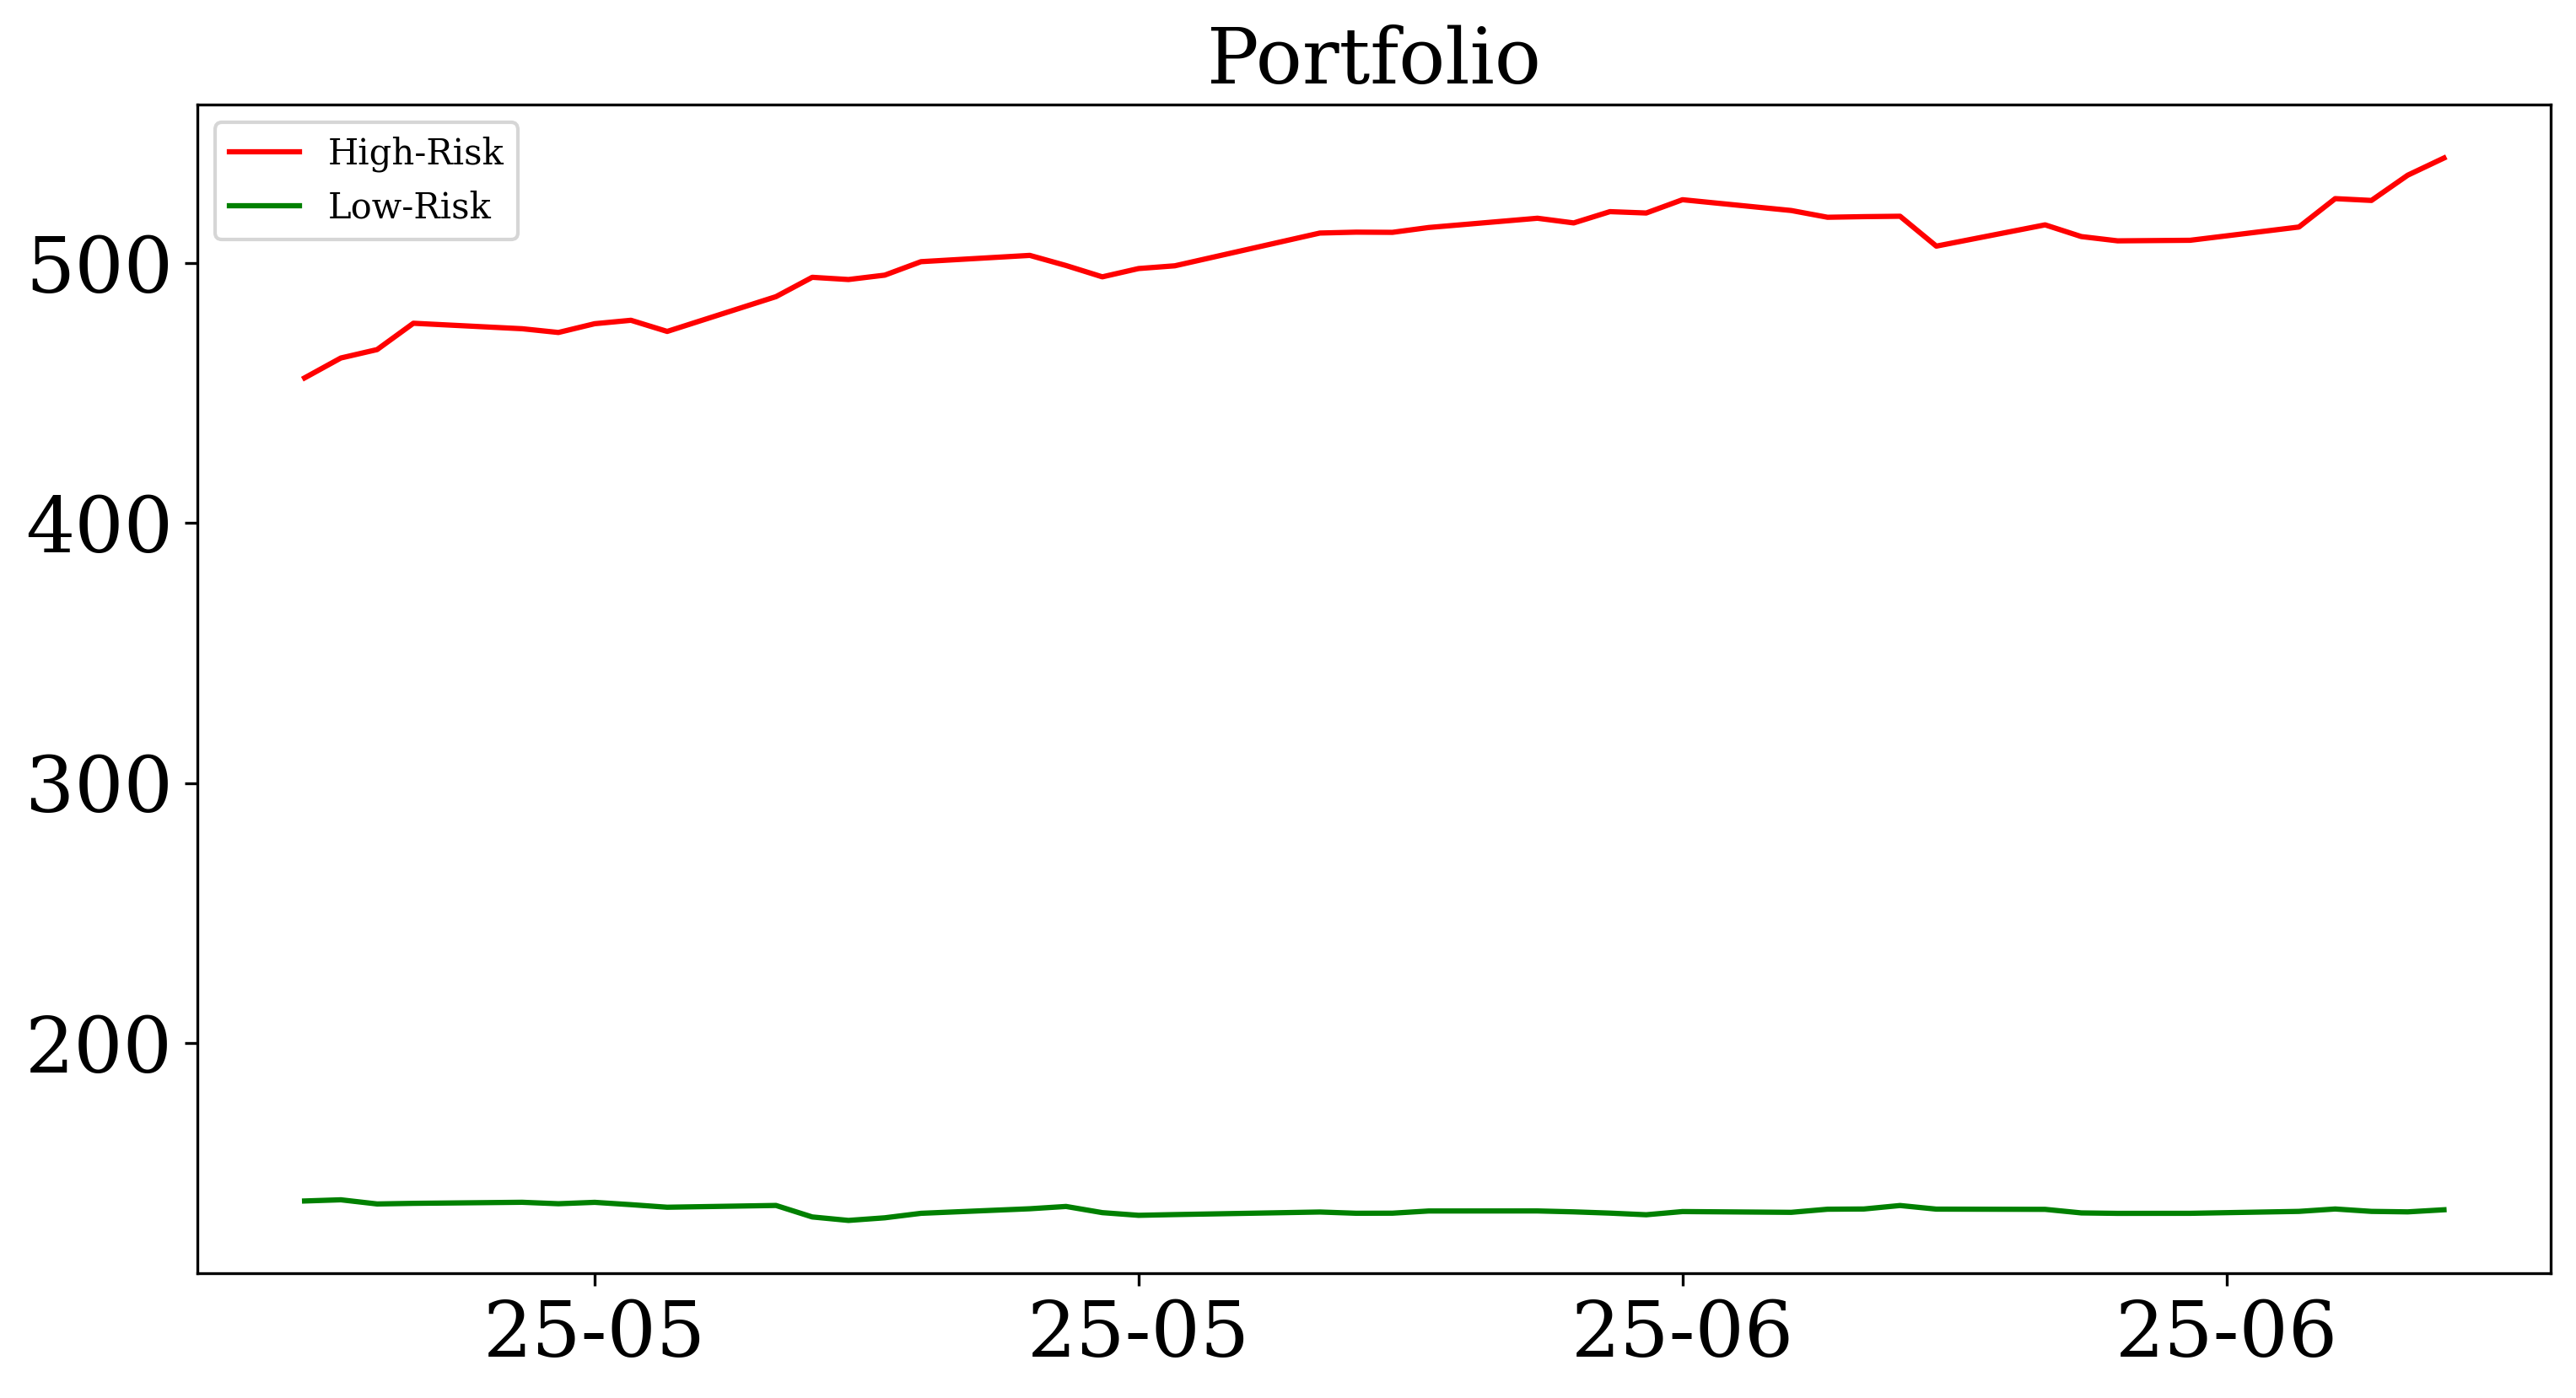

In [42]:
def ComputeLogReturnsPortfolio(PortfolioTickers,PortfolioWeights,StartDate,EndDate):
    """
    Info: Downloads the stock data and computes the log returns of a given portfolio tickers and weights
    
    Params:
        - PortfolioTickers (list of str)  : List of ticker variables of assets in the portfolio
        - PortolioWeights (list of float) : List of weights in the portfolio
        - StartDate (datetime)            : Start date to download data
        - EndDate (datetime)              : End date to download data
    """
    PortfolioData = yf.download(PortfolioTickers, start = StartDate, end = EndDate, interval = "1d")['Close']
    WeightedReturnsPortfolio = PortfolioData.mul(PortfolioWeights,axis=1).sum(axis=1)
    PortfolioReturns = WeightedReturnsPortfolio/WeightedReturnsPortfolio.shift(1)
    PortfolioLogReturns = np.log(PortfolioReturns.dropna().to_numpy())
    DateRangePortfolio = PortfolioReturns.dropna().index
    
    return WeightedReturnsPortfolio, PortfolioLogReturns, DateRangePortfolio

EndDate = dt.datetime.today()
StartDate = EndDate - pd.DateOffset(months=2)

HRPData,HRPLogRet,DateRange = ComputeLogReturnsPortfolio(HighRiskPortfolioTickers, \
                                                        WeightsHighRiskPortfolio,StartDate,EndDate)
LRPData,LRPLogRet,DateRange = ComputeLogReturnsPortfolio(LowRiskPortfolioTickers, OptimalWeightsLowRisk,\
                                                         StartDate,EndDate)
import matplotlib.dates as mdates 
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(HRPData,color='r',label="High-Risk")
ax.plot(LRPData,color='g',label="Low-Risk")
ax.xaxis.set_major_locator(plt.MaxNLocator(6)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))
ax.set_title("Portfolio")
plt.legend()
plt.show()

The difference between the two portfolios is already clear. The high-risk portfolio (red) is showing large gains, while the low-risk portfolio (green) is moving steadily with smaller changes. Tracking them over this short stretch gives instant feedback on how our choices fare in live market conditions, revealing what works, what doesn’t, and how each market move affects the portfolios.